In [3]:
import RNA
from Bio import SeqIO
import RNA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import re




In [21]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
cm = 1/2.54
data_folder = '../all_data/Supplementary_data/Sequence_analysis'

In [12]:
# Load the codon usage table and sequences from the provided Excel files
codon_table_path = data_folder+'/Coli_codon_table.csv'
sequences_path = data_folder+'/MP_CDS_sequences.csv'
bounding_sequences_path = data_folder+'/MP_bounding_sequences.csv'

# Reading the codon usage table
codon_usage_df = pd.read_csv(codon_table_path)
print(codon_usage_df.head())

# Reading the sequences
sequences_df = pd.read_csv(sequences_path)
sequences_df.head()

# Reading the bounding sequences
bounding_sequences = pd.read_csv(bounding_sequences_path)
bounding_sequences.head()

  Triplet Amino acid  Fraction  Frequency/ Thousand  Number
0     TTT          F      0.58                 22.1   80995
1     TTC          F      0.42                 16.0   58774
2     TTA          L      0.14                 14.3   52382
3     TTG          L      0.13                 13.0   47500
4     TAT          Y      0.59                 17.5   63937


,Full Name,Short Name,Sequence
0,Cell-free expression promoter,EXPpro_RBS,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...
1,Linker+GFP11+T7 terminator,G11_T7term,GGATCCGATGGAGGGTCTGGTGGCGGATCAACAAGTCGTGACCACA...


In [13]:
upstream = bounding_sequences[bounding_sequences['Short Name'] == 'EXPpro_RBS']['Sequence'].values[0]
# upstream = "gggagacacacgacggtttccctctagaaataattttgtttaactttaagaaggagataccCAT"
downstream = bounding_sequences[bounding_sequences['Short Name'] == 'G11_T7term']['Sequence'].values[0]

# Add the upstream and downstream sequences to the sequences dataframe
sequences_df['Upstream'] = upstream
sequences_df['Downstream'] = downstream
sequences_df['Full Sequence'] = sequences_df['Upstream'] + sequences_df['Sequence'] + sequences_df['Downstream']
sequences_df.head()

,Full Name,Short Name,Sequence,Upstream,Downstream,Full Sequence
0,Aquaporin Z,AqpZ,ATGTTCAGAAAATTAGCAGCTGAATGTTTTGGTACTTTCTGGCTTG...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...,GGATCCGATGGAGGGTCTGGTGGCGGATCAACAAGTCGTGACCACA...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...
1,Auxin efflux carrier-like protein 1,Aux,ATGTCTTTAACCCAGTCGGCCAAATTGCACATCATTCATCAGTCCA...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...,GGATCCGATGGAGGGTCTGGTGGCGGATCAACAAGTCGTGACCACA...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...
2,Auxin transporter protein 1,AuxT1,ATGTCAGAAGGGGTGGAGGCAATCGTGGCCAATGACAATGGTACCG...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...,GGATCCGATGGAGGGTCTGGTGGCGGATCAACAAGTCGTGACCACA...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...
3,Beta-2 adrenergic receptor,B2AR,ATGGGCCAGCCTGGGAACGGATCAGCCTTCCTTCTGGCACCCAACG...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...,GGATCCGATGGAGGGTCTGGTGGCGGATCAACAAGTCGTGACCACA...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...
4,Beta-3 adrenergic receptor,B3AR,ATGGCACCGTGGCCTCATGAAAACTCCAGCTTGGCGCCGTGGCCCG...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...,GGATCCGATGGAGGGTCTGGTGGCGGATCAACAAGTCGTGACCACA...,CCCGCGAAATTAATACGACTCACTATAGGGAGACACACGACGGTTT...


In [ ]:
# sequences_df[['Short Name', 'Full Sequence']].to_csv('MP_full_sequences.csv', index=False)

In [14]:
rbs_data = pd.read_csv(data_folder+'/RBS_calculation_all_MPs.csv')
rbs_data[['Short Name', 'tir_max']]
rbs_data = pd.merge(sequences_df, rbs_data[['Short Name', 'tir_max']], on='Short Name')
# rbs_data


In [15]:
trans_data = pd.read_csv(data_folder+'/Transcription_calcs_all_MPs.csv')
trans_data.columns = ['DNA_name','TX_max','TX_min','DNA_sequence']
trans_data = trans_data[['DNA_name','TX_max']]

In [16]:
data = pd.read_pickle('../all_data/General_data/screen_active_data.pkl')
sub_df = []
diff_threshold = 0.1

for rxn_id, df in data.groupby('rxn_id'):
    t = df.copy()
    n_sub = np.mean(t[t['Liposome_conc'] == 0]['pmol'])
    
    t['pmol_sub_nolipo'] = t['pmol'] - n_sub
    # t['ugml_sub_nolipo'] = t['ug_ml'] - n_sub
    
    l = t[t['Liposome_conc'] != 0]
    n = t[t['Liposome_conc'] == 0]
    pval = ttest_ind(l['pmol_sub_nolipo'],n['pmol_sub_nolipo'])[1]

    t['p-val'] = pval
    mean_diff = np.mean(l['pmol_sub_nolipo'])
    t['mean_diff'] = mean_diff
    if mean_diff > diff_threshold and pval < 0.05:
        t['score'] = 1
    else:
        t['score'] = 0
    sub_df.append(t)

sub_df = pd.concat(sub_df).reset_index(drop=True)
sub_df

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,...,K,WCE,PEG,pmol,rxn_id,label,pmol_sub_nolipo,p-val,mean_diff,score
0,eCM313,1.0,1.0,H12,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,4.917841,0.0,screen,2.687854,0.006012,3.159217,1
1,eCM313,1.0,1.0,K12,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,4.311317,0.0,screen,2.081330,0.006012,3.159217,1
2,eCM313,1.0,1.0,M5,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,2.643803,0.0,screen,0.413816,0.006012,3.159217,1
3,eCM313,2.0,4.0,J2,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,7.546170,0.0,screen,5.316182,0.006012,3.159217,1
4,eCM313,2.0,4.0,N22,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,7.526887,0.0,screen,5.296900,0.006012,3.159217,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,eCM313,1.0,2.0,C22,S22,Vol,5.0,no_lipo,0,20.0,...,135,BL62,2.0,1.915398,3966.0,screen,0.238102,0.095478,-0.414692,0
11193,eCM313,1.0,2.0,N11,S22,Vol,5.0,no_lipo,0,20.0,...,135,BL62,2.0,1.529072,3966.0,screen,-0.148223,0.095478,-0.414692,0
11194,eCM313,2.0,3.0,A1,S22,Vol,5.0,no_lipo,0,20.0,...,135,BL62,2.0,1.148607,3966.0,screen,-0.528689,0.095478,-0.414692,0
11195,eCM313,2.0,4.0,B2,S22,Vol,5.0,no_lipo,0,20.0,...,135,BL62,2.0,1.264765,3966.0,screen,-0.412530,0.095478,-0.414692,0


C:\Users\conar\AppData\Local\Temp\ipykernel_5652\1411061452.py:11: FutureWarning: The provided callable <function max at 0x000001FF1C93D1C0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  temp = temp.groupby('DNA_name')[['mean_diff']].agg(np.max).reset_index()


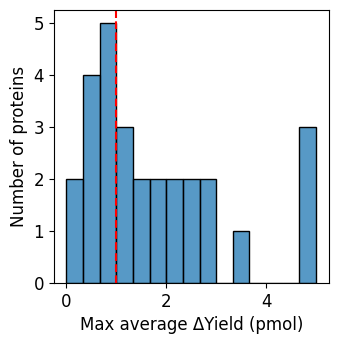

['B2AR', 'B3AR', 'CD63', 'CD81', 'CML1', 'Cx43', 'FFAR4', 'Neu', 'OR1D2', 'OR1E1', 'OR2AG1']
11


In [17]:
plt.rcParams['font.size'] = 12
cm = 1/2.54
fig,ax = plt.subplots(figsize=[9*cm,9*cm])

significance_threshold = 0.05
difference_threshold = 1

temp = sub_df[sub_df['Liposome_name'] != 'no_lipo'].drop_duplicates(subset=['rxn_id'])
temp = temp[['DNA_name','mean_diff','p-val','score']]
temp = temp[temp['p-val'] < significance_threshold]
temp = temp.groupby('DNA_name')[['mean_diff']].agg(np.max).reset_index()
temp['mean_diff_clipped'] = temp['mean_diff'].clip(0,5)
sns.histplot(temp,x='mean_diff_clipped',ax=ax,bins=15)
plt.axvline(difference_threshold,c='r',ls='--',lw=1.5)
plt.xlabel('Max average ΔYield (pmol)')
plt.ylabel('Number of proteins')
exp_data = temp.copy()

plt.show()
low = temp[temp['mean_diff'] <= difference_threshold]['DNA_name'].tolist()
print(low)
print(len(low))
plt.rcParams['font.size'] = 7

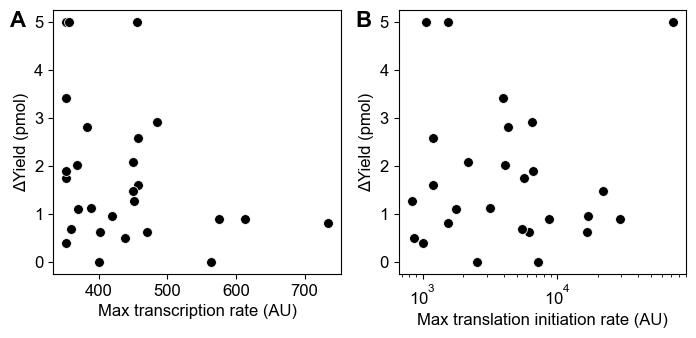

In [37]:
rbs_data = rbs_data.rename(columns={'Short Name':'DNA_name'})
rbs_exp = pd.merge(rbs_data, exp_data, on='DNA_name')
rbs_exp = pd.merge(rbs_exp, trans_data, on='DNA_name')

fig, axs = plt.subplots(1, 2, figsize=(18*cm, 9*cm))

# Plot for transcription rate
sns.scatterplot(data=rbs_exp, x='TX_max', y='mean_diff_clipped', s=50, color='k', ax=axs[0])
axs[0].set_ylabel('ΔYield (pmol)')
axs[0].set_xlabel('Max transcription rate (AU)')
axs[0].text(-0.15, 0.92, 'A', ha='left', va='bottom', transform=axs[0].transAxes, fontsize=16, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot for translation initiation rate
sns.scatterplot(data=rbs_exp, x='tir_max', y='mean_diff_clipped', s=50, color='k', ax=axs[1])
axs[1].set_ylabel('ΔYield (pmol)')
axs[1].set_xlabel('Max translation initiation rate (AU)')
axs[1].set_xscale('log')
axs[1].text(-0.15, 0.92, 'B', ha='left', va='bottom', transform=axs[1].transAxes, fontsize=16, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.tight_layout()
plt.show()

# rbs_exp[rbs_exp['DNA_name'] == 'Vol']


In [19]:
lipo = sub_df[sub_df['Liposome_name'] != 'no_lipo'].drop_duplicates(subset=['rxn_id'])
lipo

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,...,K,WCE,PEG,pmol,rxn_id,label,pmol_sub_nolipo,p-val,mean_diff,score
0,eCM313,1.0,1.0,H12,S22,AqpZ,5.0,DMPC,3,8.0,...,85,BL62,2.0,4.917841,0.0,screen,2.687854,6.012167e-03,3.159217,1
11,eCM336,1.0,1.0,H2,S26,AqpZ,5.0,DMPC,3,8.0,...,85,BL65,0.0,11.500856,1.0,active,5.156452,1.915773e-03,4.796656,1
19,eCM331,1.0,2.0,G9,S26,AqpZ,5.0,DMPC,3,8.0,...,85,BL65,2.0,7.030161,2.0,screen,3.790737,1.090801e-04,4.039171,1
26,eCM313,1.0,2.0,E6,S22,AqpZ,5.0,DMPC,3,8.0,...,135,BL62,2.0,4.030212,3.0,screen,2.475068,6.598244e-05,3.831750,1
37,eCM336,1.0,1.0,F10,S26,AqpZ,5.0,DMPC,3,8.0,...,135,BL65,0.0,12.064952,4.0,active,7.236825,3.957367e-08,7.516283,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11143,eCM313,1.0,1.0,P4,S22,Vol,5.0,DOPC,3,20.0,...,135,BL62,2.0,1.186308,3953.0,screen,-0.413117,8.282475e-02,-0.286527,0
11154,eCM317,1.0,3.0,D6,S23,Vol,5.0,DOPC,3,20.0,...,185,BL62,0.0,3.311356,3954.0,active,-0.327971,8.070727e-01,0.085506,0
11164,eCM317,1.0,3.0,O17,S23,Vol,5.0,DOPC,3,20.0,...,185,BL62,0.0,4.279837,3964.0,active,1.042550,3.294639e-01,0.477418,0
11174,eCM313,1.0,1.0,F14,S22,Vol,5.0,DOPC,3,20.0,...,85,BL62,2.0,1.773103,3965.0,screen,-0.129566,3.587318e-02,-0.372422,0


In [ ]:
from statsmodels.stats.multitest import multipletests

def apply_multiple_testing_correction(df, alpha=0.05, method='fdr_bh'):
    corrected_pvals = {}
    # Group the data by protein
    for protein, group in df.groupby('DNA_name'):
        p_values = group['p-val'].values
        # Apply the multiple testing correction
        _, corrected_pvals[protein], _, _ = multipletests(p_values, alpha=alpha, method=method)
        
        # Add corrected p-values to the DataFrame
        df.loc[group.index, 'Corrected_P_value'] = corrected_pvals[protein]
    
    return df

def apply_bonferroni(df, alpha=0.05, method='bonferroni'):
    corrected_pvals = {}
    # Group the data by protein
    for protein, group in df.groupby('DNA_name'):
        p_values = group['p-val'].values
        # Apply the multiple testing correction
        _, corrected_pvals[protein], _, _ = multipletests(p_values, alpha=alpha, method=method)
        
        # Add corrected p-values to the DataFrame
        df.loc[group.index, 'Corrected_P_value'] = corrected_pvals[protein]
    
    return df

# Apply the correction
df_corrected = apply_multiple_testing_correction(lipo[['DNA_name', 'p-val','mean_diff']].copy())
# df_corrected = apply_bonferroni(lipo[['DNA_name', 'p-val','mean_diff']].copy())
print(df_corrected)

      DNA_name         p-val  mean_diff  Corrected_P_value
0         AqpZ  6.012167e-03   3.159217           0.462937
11        AqpZ  1.915773e-03   4.796656           0.147514
19        AqpZ  1.090801e-04   4.039171           0.008399
26        AqpZ  6.598244e-05   3.831750           0.005081
37        AqpZ  3.957367e-08   7.516283           0.000003
...        ...           ...        ...                ...
11143      Vol  8.282475e-02  -0.286527           1.000000
11154      Vol  8.070727e-01   0.085506           1.000000
11164      Vol  3.294639e-01   0.477418           1.000000
11174      Vol  3.587318e-02  -0.372422           1.000000
11186      Vol  9.547845e-02  -0.414692           1.000000

[1251 rows x 4 columns]


In [21]:
def determine_success(df, p_value_threshold=0.05, yield_difference_threshold=1.0):
    df['Success'] = (df['Corrected_P_value'] < p_value_threshold) & (df['mean_diff'] > yield_difference_threshold)
    df['Success-original'] = (df['p-val'] < p_value_threshold) & (df['mean_diff'] > yield_difference_threshold)
    
    # Summarize success for each protein
    success_summary = df.groupby('DNA_name')['Success'].any().reset_index()
    success_summary_original = df.groupby('DNA_name')['Success-original'].any().reset_index()

    full_summary = success_summary.merge(success_summary_original,on='DNA_name')
    return full_summary

# Determine success based on corrected p-values
success_summary = determine_success(df_corrected)
success_summary['comparison'] = success_summary['Success'] == success_summary['Success-original']
success_summary

,DNA_name,Success,Success-original,comparison
0,AqpZ,True,True,True
1,Aux,True,True,True
2,B2AR,False,False,True
3,B3AR,False,False,True
4,Beta,True,True,True
5,CD47,True,True,True
6,CD63,False,False,True
7,CD81,False,False,True
8,CD9,True,True,True
9,CML1,False,False,True


In [22]:
# Prepare the codon usage dictionary with the correct column names
codon_usage_dict = dict(zip(codon_usage_df['Triplet'], codon_usage_df['Frequency/ Thousand']))
# Adjust the frequency values to match the original scale
codon_usage_dict = {codon: freq / 1000 for codon, freq in codon_usage_dict.items()}
print(codon_usage_dict)

{'TTT': 0.0221, 'TTC': 0.016, 'TTA': 0.0143, 'TTG': 0.013, 'TAT': 0.0175, 'TAC': 0.012199999999999999, 'TAA': 0.002, 'TAG': 0.0003, 'CTT': 0.0119, 'CTC': 0.010199999999999999, 'CTA': 0.004200000000000001, 'CTG': 0.0484, 'CAT': 0.0125, 'CAC': 0.009300000000000001, 'CAA': 0.0146, 'CAG': 0.028399999999999998, 'ATT': 0.0298, 'ATC': 0.0237, 'ATA': 0.0068, 'ATG': 0.0264, 'AAT': 0.0206, 'AAC': 0.0214, 'AAA': 0.0353, 'AAG': 0.0124, 'GTT': 0.0198, 'GTC': 0.0143, 'GTA': 0.0116, 'GTG': 0.024399999999999998, 'GAT': 0.0327, 'GAC': 0.0192, 'GAA': 0.0391, 'GAG': 0.018699999999999998, 'TCT': 0.0104, 'TCC': 0.0091, 'TCA': 0.0089, 'TCG': 0.0085, 'TGT': 0.0052, 'TGC': 0.0060999999999999995, 'TGA': 0.001, 'TGG': 0.013900000000000001, 'CCT': 0.0075, 'CCC': 0.0054, 'CCA': 0.0086, 'CCG': 0.0209, 'CGT': 0.02, 'CGC': 0.0197, 'CGA': 0.0038, 'CGG': 0.005900000000000001, 'ACT': 0.0103, 'ACC': 0.022, 'ACA': 0.009300000000000001, 'ACG': 0.013699999999999999, 'AGT': 0.0099, 'AGC': 0.0152, 'AGA': 0.0036, 'AGG': 0.002

0.004500000000000001


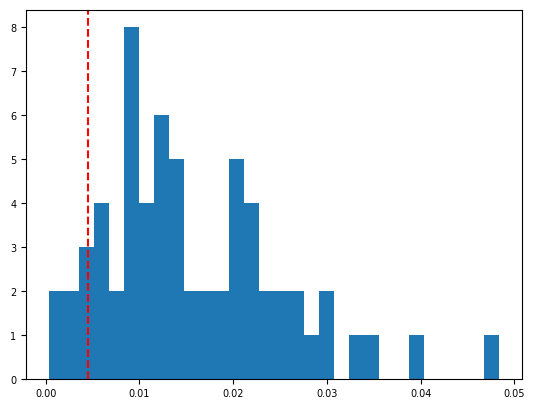

In [23]:
# Plot the distribution of codon frequencies to set the threshold for a rare codon
plt.hist(codon_usage_dict.values(), bins=30)
# Plot a horizontal line at the threshold value, which is set to the value that divides the codon frequencies into 10% rare and 90% common
threshold = np.percentile(list(codon_usage_dict.values()), 10)
print(threshold)
plt.axvline(threshold, color='r', linestyle='--')

In [24]:
# Read in list of rare codon pairs from "Computational identification of rare codons of Escherichia coli based on codon pairs preference" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2828438/
codon_pairs = pd.read_csv('rare_codon_pairs.csv')
rare_pairs = codon_pairs['codon_pair'].values


In [26]:
# Define a function to calculate the rare codon count in a sequence
def calculate_rare_codon_count(sequence, codon_usage_dict, threshold=0.01):
    codon_count = {codon: 0 for codon in codon_usage_dict.keys()}
    partial_sequence = sequence
    total_codons = len(partial_sequence) // 3
    rare_codon_count = 0
    
    for i in range(0, len(partial_sequence) - 2, 3):
        codon = sequence[i:i+3]
        if codon in codon_count:
            codon_count[codon] += 1
            # Count as rare if the frequency is below the threshold
            if codon_usage_dict[codon] < threshold:
                rare_codon_count += 1
    
    codon_usage_freq = {codon: count / total_codons for codon, count in codon_count.items()}
    return rare_codon_count

# Function to calculate free energy of RNA structure for various windows
def calculate_rna_free_energy_scanning(sequence, start_points, window_lengths):
    mfe_results = {}
    for start in start_points:
        for window in window_lengths:
            if start + window <= len(sequence):
                subsequence = sequence[start:start + window]
                structure, mfe = RNA.fold(subsequence)
                mfe_results[(start, window)] = mfe
    return mfe_results

# Function to check for repeated prolines in the sequence
def check_proline_repeats(sequence, repeat_length=3):
    proline_codon = "CCT"
    repeat_sequence = proline_codon * repeat_length
    return repeat_sequence in sequence


def is_one_base_off(seq1, seq2):
    """
    Check if seq1 is exactly one base off from seq2.
    """
    if len(seq1) != len(seq2):
        return False
    return sum(1 for a, b in zip(seq1, seq2) if a != b) == 1

def find_shine_dalgarno_like_sequences(sequence, canonical_sequences=['AGGAGA', 'AGGAGG']):
    """
    Search for Shine-Dalgarno-like sequences within a coding sequence.
    Returns a list of positions where such sequences were found.
    """
    sd_positions = []
    sd_like_positions = []
    seq_length = len(canonical_sequences[0])
    
    for i in range(len(sequence) - seq_length + 1):
        subseq = sequence[i:i + seq_length]
        # Check for exact match or one base off from canonical sequences
        for canon_seq in canonical_sequences:
            if subseq == canon_seq:
                sd_positions.append((subseq, i))
                break  # Stop checking other canonical sequences for this position
            if is_one_base_off(subseq, canon_seq):
                sd_like_positions.append((subseq, i))
                break
    
    return sd_positions, sd_like_positions

def calculate_gc_content(sequence):
    """
    Calculate the GC content of a given sequence.
    """
    g_count = sequence.count('G')
    c_count = sequence.count('C')
    gc_content = (g_count + c_count) / len(sequence) * 100
    return gc_content

def max_average_gc_content(sequence, window_size, step_size=1):
    """
    Scan through the sequence using a defined window size, calculate the GC content in each window,
    and return the maximum average GC content across all windows tested.

    Args:
    - sequence: The nucleotide sequence (string).
    - window_size: The size of the sliding window (int).
    - step_size: The number of bases to move the window at each step (int). Default is 1.

    Returns:
    - max_gc_content: The maximum average GC content found across all windows (float).
    - max_gc_window_start: The start position of the window with the maximum GC content (int).
    """
    max_gc_content = 0
    max_gc_window_start = 0
    
    for i in range(0, len(sequence) - window_size + 1, step_size):
        window_sequence = sequence[i:i + window_size]
        gc_content = calculate_gc_content(window_sequence)
        
        if gc_content > max_gc_content:
            max_gc_content = gc_content
            max_gc_window_start = i
    
    return max_gc_content, max_gc_window_start

def count_rare_codon_pairs(sequence, rare_codon_pairs):
    """
    Scan the sequence for the presence of rare codon pairs.

    Args:
    - sequence: The nucleotide sequence (string) in frame.
    - rare_codon_pairs: A list of 6-character strings, each representing a rare codon pair.

    Returns:
    - rare_codon_pair_count: The number of rare codon pairs found in the sequence.
    - positions: A list of positions (start index) where each rare codon pair was found.
    """
    rare_codon_pair_count = 0
    positions = []
    
    # Scan the sequence for each rare codon pair
    for i in range(0, len(sequence) - 5, 3):  # Move in steps of 3 (codon length)
        codon_pair = sequence[i:i + 6]
        if codon_pair in rare_codon_pairs:
            rare_codon_pair_count += 1
            positions.append(i)
    
    return rare_codon_pair_count


# Function to run the full analysis on each sequence
def analyze_sequence(sequence, codon_usage_dict,start_points=[50, 80], window_lengths=[50, 80], threshold=0.01):
    cds_sequence = sequence[91:-183]
    rare_codon_count = calculate_rare_codon_count(cds_sequence, codon_usage_dict,threshold=threshold)
    start_mfe = calculate_rna_free_energy_scanning(sequence,start_points,window_lengths)
    proline_repeats = check_proline_repeats(sequence)
    sd_positions,sd_like_positions = find_shine_dalgarno_like_sequences(cds_sequence)
    num_sd_positions = len(sd_positions)
    num_sd_like_positions = len(sd_like_positions)
    max_gc_content,_ = max_average_gc_content(cds_sequence,20)
    rare_pair_count = count_rare_codon_pairs(cds_sequence, rare_pairs)
    
    return rare_codon_count, start_mfe, proline_repeats, num_sd_positions, num_sd_like_positions, max_gc_content, rare_pair_count


In [27]:
start_points = [50,60, 70, 80, 90, 100]
window_lengths = [10,20,30,40,50]
# Apply the analysis to each sequence in the sequences dataframe
analysis_results = sequences_df['Full Sequence'].apply(lambda seq: analyze_sequence(seq, codon_usage_dict,start_points=start_points,window_lengths=window_lengths,threshold=threshold))

# Extract the results into separate columns
sequences_df['Rare Codon Count'] = analysis_results.apply(lambda x: x[0])
sequences_df['RNA Free Energy (MFE)'] = analysis_results.apply(lambda x: x[1])
sequences_df['Proline Repeats'] = analysis_results.apply(lambda x: x[2])
sequences_df['SD Positions'] = analysis_results.apply(lambda x: x[3])
sequences_df['SD-like Positions'] = analysis_results.apply(lambda x: x[4])
sequences_df['Max_GC_Content'] = analysis_results.apply(lambda x: x[5])
sequences_df['Rare Codon Pair Count'] = analysis_results.apply(lambda x: x[6])

# Display the results
sequences_df[['Full Name', 'Short Name', 'Rare Codon Count', 'RNA Free Energy (MFE)', 'Proline Repeats', 'SD Positions', 'SD-like Positions', 'Max_GC_Content', 'Rare Codon Pair Count']].head()

,Full Name,Short Name,Rare Codon Count,RNA Free Energy (MFE),Proline Repeats,SD Positions,SD-like Positions,Max_GC_Content,Rare Codon Pair Count
0,Aquaporin Z,AqpZ,0,"{(50, 10): 0.0, (50, 20): -0.8999999761581421,...",False,0,1,90.0,4
1,Auxin efflux carrier-like protein 1,Aux,0,"{(50, 10): 0.0, (50, 20): -1.899999976158142, ...",False,0,7,85.0,16
2,Auxin transporter protein 1,AuxT1,0,"{(50, 10): 0.0, (50, 20): -1.399999976158142, ...",False,0,10,80.0,12
3,Beta-2 adrenergic receptor,B2AR,0,"{(50, 10): 0.0, (50, 20): -3.5999999046325684,...",False,2,10,75.0,16
4,Beta-3 adrenergic receptor,B3AR,7,"{(50, 10): 0.0, (50, 20): -0.8999999761581421,...",False,0,4,95.0,8


In [28]:
# Join the analysis results with the experimental data
full_data = pd.merge(exp_data, sequences_df, left_on='DNA_name', right_on='Short Name', how='inner')
full_data = full_data.drop(columns=['Short Name', 'Sequence', 'Upstream', 'Downstream'])
full_data = full_data.rename(columns={'mean_diff_clipped': 'Yield'})


C:\Users\conar\AppData\Local\Temp\ipykernel_21016\2079520489.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_xticks(np.arange(int(min(x)), int(max(x)) + 1, 2))
C:\Users\conar\AppData\Local\Temp\ipykernel_21016\2079520489.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_xticks(np.arange(int(min(x)), int(max(x)) + 1, 2))
C:\Users\conar\AppData\Local\Temp\ipykernel_21016\2079520489.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_xtic

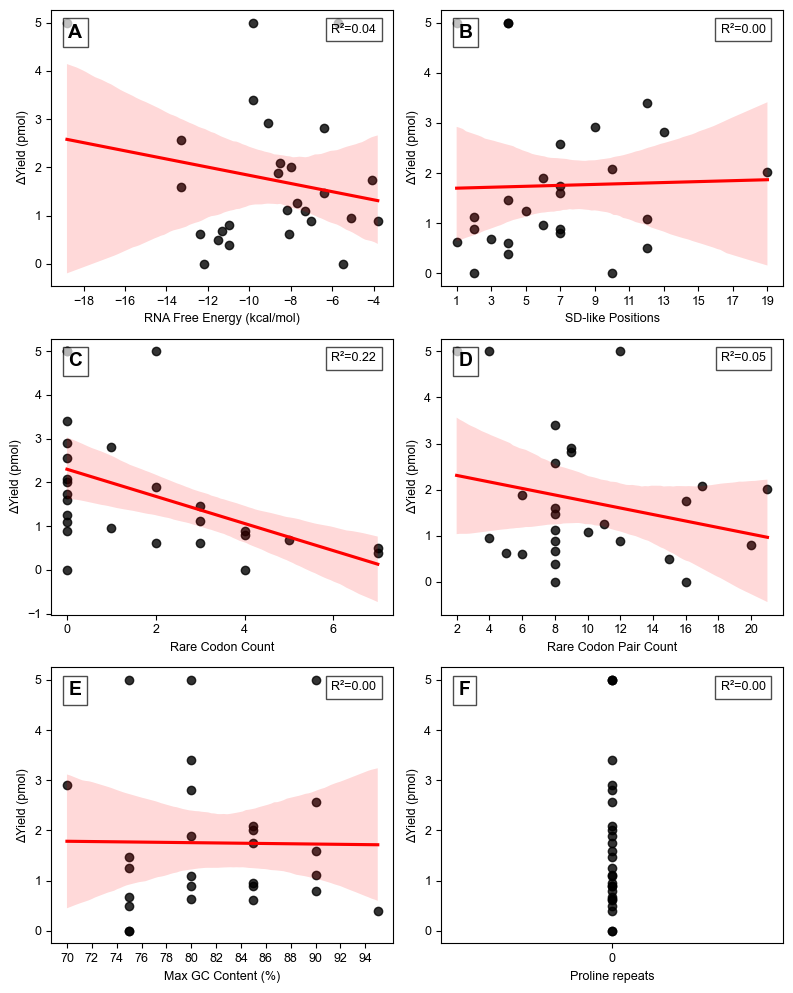

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

def plot_with_fit(x, y, ax, title, x_label, y_label):
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Fit the model
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    r_squared = r2_score(y, y_pred)
    
    # Scatter plot
    # ax.scatter(x, y, label='Data points', color='k')
    # ax.plot(x, y_pred, color='red', label=f'Fit (R²={r_squared:.2f})')
    sns.regplot( x=x, y=y, ax=ax, scatter=True,color='k',line_kws={'color':'red'})
    # Add r-squared value to the plot (positioned in the top right) inside a text box
    ax.text(0.95, 0.95, f'R²={r_squared:.2f}', ha='right', va='top', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    # ax.set_title(title)
    # ax.legend()
    
    # Set X-axis ticks to show only whole numbers
    ax.set_xticks(np.arange(int(min(x)), int(max(x)) + 1, 2))

    # Add a capital letter label to the top left of the plot, large and bold inside a text box
    ax.text(0.05, 0.95, title, ha='left', va='top', transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

# Example usage in a plotting context
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Arial'

fig, axs = plt.subplots(3, 2, figsize=(8, 10))

mfe_values = [mfe_dict[(50, 50)] for mfe_dict in full_data['RNA Free Energy (MFE)']]
plot_with_fit(mfe_values, full_data['Yield'], axs[0, 0], 'A', 'RNA Free Energy (kcal/mol)', 'ΔYield (pmol)')

SD_like_numeric = full_data['SD-like Positions'].astype(int)  # Convert boolean to numeric for plotting
plot_with_fit(SD_like_numeric, full_data['Yield'], axs[0, 1], 'B', 'SD-like Positions', 'ΔYield (pmol)')

# Plot Rare Codon Count vs Yield
plot_with_fit(full_data['Rare Codon Count'], full_data['Yield'], axs[1, 0], 'C', 'Rare Codon Count', 'ΔYield (pmol)')
plot_with_fit(full_data['Rare Codon Pair Count'], full_data['Yield'], axs[1, 1], 'D', 'Rare Codon Pair Count', 'ΔYield (pmol)')

plot_with_fit(full_data['Max_GC_Content'], full_data['Yield'], axs[2, 0], 'E', 'Max GC Content (%)', 'ΔYield (pmol)')

proline_numeric = full_data['Proline Repeats'].astype(int)  # Convert boolean to numeric for plotting
plot_with_fit(proline_numeric, full_data['Yield'], axs[2, 1], 'F', 'Proline repeats', 'ΔYield (pmol)')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Function to calculate and plot the best fit line and r-squared value
def plot_with_fit(x, y, ax, title):
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Fit the model
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    r_squared = r2_score(y, y_pred)
    
    # Scatter plot
    ax.scatter(x, y, label='Data points')
    ax.plot(x, y_pred, color='red', label=f'Fit (R²={r_squared:.2f})')
    ax.set_title(title)
    ax.legend()


# Prepare the figure: adjust the grid size to accommodate all plots
num_plots = len(start_points) * len(window_lengths)
cols = 3  # Number of columns for the subplots
rows = (num_plots // cols) + int(num_plots % cols > 0)  # Calculate the number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()  # Flatten the axis array for easier indexing

# Iterate over start points and window lengths
plot_idx = 0
for start in start_points:
    for window in window_lengths:
        # Extract MFE values for the current start and window
        mfe_values = [mfe_dict.get((start, window), np.nan) for mfe_dict in full_data['RNA Free Energy (MFE)']]
        
        # Plot the results
        plot_with_fit(mfe_values, full_data['Yield'], axs[plot_idx], f'Start={start}, Window={window}')
        
        plot_idx += 1

# Final adjustments
for i in range(plot_idx, len(axs)):
    fig.delaxes(axs[i])  # Remove unused subplots

plt.tight_layout()
plt.show()

In [ ]:
# Plot the relationship between the maximum average yield difference clipped and each of the features using a loop
# The best fit line and R-squared value are also displayed
plt.rcParams['font.size'] = 9
cm = 1/2.54
fig, axes = plt.subplots(2, 2, figsize=(18*cm, 18*cm))
for i, feature in enumerate(['Rare Codon Count', 'RNA Free Energy (MFE)-50', 'RNA Free Energy (MFE)-80', 'Proline Repeats']):
    # sns.scatterplot(data=full_data, x=feature, y='mean_diff_clipped', ax=axes[i // 2, i % 2])
    sns.regplot(data=full_data, x=feature, y='mean_diff_clipped', ax=axes[i // 2, i % 2], scatter=True)
    axes[i // 2, i % 2].set_xlabel(feature)
    axes[i // 2, i % 2].set_ylabel('Max average ΔYield (pmol)')
plt.tight_layout()
plt.show()

In [ ]:
# Plot the relationship between the rare codon count and the maximum average yield difference clipped
plt.rcParams['font.size'] = 12
cm = 1/2.54
fig, ax = plt.subplots(figsize=[9*cm, 9*cm])
sns.scatterplot(data=full_data, x='Rare Codon Count', y='mean_diff_clipped', ax=ax)
plt.xlabel('Rare Codon Count')
plt.ylabel('Max average ΔYield (pmol)')
plt.show()


In [ ]:
# Plot the relationship between the RNA free energy near the start codon and the maximum average yield difference clipped
plt.rcParams['font.size'] = 12
cm = 1/2.54
fig, ax = plt.subplots(figsize=[9*cm, 9*cm])
sns.scatterplot(data=full_data, x='RNA Free Energy (MFE)-50', y='mean_diff_clipped', ax=ax)
plt.xlabel('RNA Free Energy (MFE)-50')
plt.ylabel('Max average ΔYield (pmol)')
plt.show()